# Chapter 02-1. Pandas 아키텍처와 메모리 최적화

실무에서 수십 GB의 데이터를 다룰 때 가장 먼저 마주하는 벽은 **'Out of Memory(OOM)'** 에러입니다. 
Pandas의 내부 구조인 **Block Manager**를 이해하고, 메모리 점유율을 최소화하는 엔지니어링 기법을 학습합니다.

### 1.1 데이터 타입 다운캐스팅 (Downcasting)
Pandas는 데이터를 읽을 때 보수적으로 가장 큰 메모리 공간(`int64`, `float64`)을 할당합니다. 
이를 데이터의 실제 범위에 맞는 최소 타입으로 줄여 메모리를 70~80% 이상 절감합니다.

- **int64**: 8바이트 (약 -922경 ~ 922경)
- **int8**: 1바이트 (-128 ~ 127) -> 나이, 점수 등 작은 수치에 적합

In [11]:
import pandas as pd
import numpy as np

# [데이터 생성 단계] 실습을 위한 가상 데이터 100만 개 생성
# np.arange(1000000): 0부터 999,999까지의 순차적인 정수 배열 생성 (ID로 사용)
# np.random.randint(0, 100, 1000000): 0부터 99 사이의 랜덤 정수 100만 개 생성 (나이 데이터)
# np.random.uniform(0, 100, 1000000): 0부터 99.9... 사이의 랜덤 실수 100만 개 생성 (점수 데이터)
df = pd.DataFrame({
    'ID': np.arange(1000000),                 # 기본적으로 int64 (8바이트) 정수형이 할당됨
    'Age': np.random.randint(0, 100, 1000000), # 기본적으로 int64 (8바이트) 정수형이 할당됨
    'Score': np.random.uniform(0, 100, 1000000) # 기본적으로 float64 (8바이트) 실수형이 할당됨
})

# [메모리 측정 1] 최적화 전 데이터프레임의 메모리 사용량 측정
# memory_usage(deep=True): 각 컬럼별 메모리 사용량을 바이트 단위로 반환 (deep=True는 object 타입의 실제 크기까지 정확히 계산)
# .sum(): 전체 컬럼의 합계 계산
# / 1024**2: 바이트(Byte) 단위를 메가바이트(MB)로 변환 (1024*1024)
before_mem = df.memory_usage(deep=True).sum() / 1024**2

# [데이터 최적화 단계 - Downcasting]
# pd.to_numeric 함수를 사용하여 데이터의 크기에 맞는 가장 작은 데이터 타입으로 변환합니다.

# 1. ID 컬럼 최적화: downcast='unsigned'
#    - 음수가 없는 정수형 데이터를 위한 옵션입니다. 
#    - 100만개를 담을 수 있는 가장 작은 Unsigned Integer 타입으로 변환 (예: uint32)
df['ID'] = pd.to_numeric(df['ID'], downcast='unsigned')

# 2. Age 컬럼 최적화: downcast='integer'
#    - 일반 정수형 데이터를 위한 옵션입니다.
#    - 범위가 0~99이므로 아주 작은 메모리 공간을 차지하는 int8 타입 등으로 자동 변환됩니다.
df['Age'] = pd.to_numeric(df['Age'], downcast='integer')

# 3. Score 컬럼 최적화: downcast='float'
#    - 실수형 데이터를 위한 옵션입니다.
#    - 기본적인 float64(8바이트)를 정밀도를 크게 해치지 않는 선에서 float32(4바이트)로 줄입니다.
df['Score'] = pd.to_numeric(df['Score'], downcast='float')

# [메모리 측정 2] 최적화 후 메모리 사용량 재측정
after_mem = df.memory_usage(deep=True).sum() / 1024**2

# [결과 출력]
print("========================================")
print(f" 최적화 전 메모리: {before_mem:.2f} MB")
print(f" 최적화 후 메모리: {after_mem:.2f} MB")
print(f" 메모리 절감률:   {(1 - after_mem/before_mem)*100:.1f}%")
print("========================================")

"""
[ 🛠️ 상세 주석 및 분석 리포트 ]

1. to_numeric() 함수의 downcast 파라미터:
   - 이 기능은 데이터의 ‘최소/최대값’을 확인하여, 해당 데이터를 담을 수 있는 가장 작은 비트(bit) 크기의 자료형을 자동으로 찾아줍니다.
   - 예: 0~100 사이의 숫자는 64비트(int64) 대신 8비트(int8)만 있어도 충분히 표현 가능하므로 1/8 크기로 줄어듭니다.
   
2. 메모리 최적화의 중요성 (Engineering Insight):
   - 단순히 RAM 용량을 아끼는 것을 넘어, CPU 캐시 히트율(Cache Hit Rate)을 높여 데이터 처리 속도를 획기적으로 향상시킵니다.
   - 대용량 데이터 전처리 파이프라인에서 가장 먼저 수행해야 할 필수 단계 중 하나입니다.

3. 시간 복잡도: O(N)
   - 데이터의 개수(N)만큼 순회하며 타입을 변환하므로 선형 시간이 소요됩니다.
   
4. 실행 권장 환경: Pandas 2.0 이상
"""

### 1.2 Category 타입 변환 (Object vs Category)
문자열(`object`) 데이터는 메모리 효율이 매우 낮습니다. 
중복된 값이 많은 범주형 데이터는 **Category** 타입으로 변환하여 인덱스 방식으로 관리하면 메모리를 획기적으로 줄일 수 있습니다.

- **Object**: 모든 문자열을 메모리에 개별적으로 저장.
- **Category**: 고유값(Unique Value)은 한 번만 저장하고 나머지는 숫자로 치환하여 참조.

In [12]:
# [데이터 준비] 100만 개의 데이터 중 'City' 정보 생성 (서울, 부산, 대구 중복 발생)
# np.random.choice: 주어진 리스트에서 랜덤하게 선택하여 새로운 배열 생성
cities = ['Seoul', 'Busan', 'Daegu']
df_city = pd.DataFrame({'City': np.random.choice(cities, 1000000)})

# [메모리 측정 1] 변환 전 메모리 (Object 타입)
mem_obj = df_city.memory_usage(deep=True).sum() / 1024**2

# [최적화] Category 타입으로 변환
# astype('category'): 문자열 데이터를 카테고리형으로 변환
# 내부적으로는 'Seoul' -> 0, 'Busan' -> 1 처럼 정수 매핑 테이블을 생성하여 관리함
df_city['City'] = df_city['City'].astype('category')

# [메모리 측정 2] 변환 후 메모리 (Category 타입)
mem_cat = df_city.memory_usage(deep=True).sum() / 1024**2

# [결과 출력]
print("========================================")
print(f" Object 타입 메모리:   {mem_obj:.2f} MB")
print(f" Category 타입 메모리: {mem_cat:.2f} MB")
print(f" 메모리 효율 향상:     {mem_obj / mem_cat:.1f}배 절감")
print("========================================")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. astype('category')의 원리:
   - 문자열 자체를 반복 저장하는 대신, 고유값(Unique) 별로 정수 ID를 부여하고 별도의 매핑 테이블(Dictionary)로 관리합니다.
   - 데이터의 종류(Cardinality)가 적고 반복(Redundancy)이 많을수록 메모리 압축 효과가 극대화됩니다.
   
2. 주의사항 (Trade-off):
   - 만약 모든 값이 다른(Unique) 데이터(예: 주민등록번호, UUID)에 적용하면, 매핑 테이블 오버헤드 때문에 오히려 메모리가 증가할 수 있습니다.
"""

### 1.3 Chunk-size 로딩 (Out-of-Core Processing)
파일 용량이 전체 RAM 용량보다 클 때 사용하는 필수 기술입니다. 
전체 파일을 한 번에 읽지 않고, 지정한 행(Row) 수만큼 쪼개서 읽어 들여 순차적으로 처리합니다.

In [13]:
# 가상의 대용량 파일이 있다고 가정하고 로직을 구성합니다.
# filename = "large_dataset.csv"

def process_by_chunks(filename):
    chunk_size = 100000  # [설정] 한 번에 읽어올 행(Row)의 수 (여기서는 10만 개)
    total_valid_rows = 0
    
    print(">>> 대용량 데이터 분할 처리 시작")
    
    # [핵심] pd.read_csv에 chunksize 파라미터를 지정하면 DataFrame이 아닌 TextFileReader 객체(Iterator)를 반환합니다.
    reader = pd.read_csv(filename, chunksize=chunk_size)
    
    # Iterator를 순회하며 메모리에 chunk_size만큼만 로드하여 처리
    for i, chunk in enumerate(reader):
        # 1. 쪼개진 데이터(chunk) 필터링 (메모리에는 10만 개만 존재함)
        filtered_data = chunk[chunk['Score'] > 80]
        
        # 2. 필요한 정보 집계 (여기서는 건수만 누적)
        total_valid_rows += len(filtered_data)
        
        # 3. 진행 상황 모니터링
        print(f" Chunk {i+1:02d} 처리 중... (누적 유효 데이터: {total_valid_rows:,})")
        
        # 루프가 끝나면 현재 'chunk' 변수는 메모리에서 해제되거나 다음 데이터로 덮어씌워짐 (GC)
        
    print("-" * 40)
    print(f" 처리 완료! 최종 결과: {total_valid_rows:,} 행")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. Generator/Iterator 패턴:
   - 파이썬의 제너레이터 방식을 활용하여, 전체 데이터를 메모리에 올리지 않고 스트리밍 방식으로 처리합니다.
   - 100GB 파일도 4GB 램 환경에서 처리 가능하게 만드는 핵심 기술입니다.
   
2. 분산 처리 시 주의점:
   - 각 청크별로 계산된 통계값(평균 등)을 단순 병합하면 전체 통계와 달라질 수 있습니다. 
   - 예: 전체 평균 = (청크1_합 + 청크2_합 + ...) / (청크1_개수 + 청크2_개수 + ...) 방식으로 '가중 평균'을 구해야 합니다.
"""

### 💡 디버깅 가이드: 메모리 에러(OOM) 원인 분석

> **[원인 분석]**
> Pandas는 데이터를 로드할 때 모든 컬럼을 최대 크기(`float64`)로 예측하려 합니다. 
> 실제 데이터 크기보다 2~3배 많은 메모리가 순간적으로 필요해지며 크래시가 발생합니다.

> **[재발 방지 팁]**
> 1. 데이터를 읽을 때부터 `dtype` 인자를 사용하여 타입을 강제하세요.
>    `pd.read_csv(file, dtype={'Age': 'int8', 'Score': 'float32'})`
> 2. 불필요한 열은 `usecols` 파라미터로 처음부터 불러오지 마세요.

# Chapter 02-2. 고속 데이터 연산 전략

Pandas 연산 속도의 핵심은 **'반복문을 얼마나 줄이느냐'**에 달려 있습니다. 
Python의 동적 타이핑 오버헤드를 피하고, 1장에서 배운 NumPy의 C-레벨 병렬 연산을 활용하는 최적화 기법을 학습합니다.

### 2.1 연산 속도의 계층 (Performance Hierarchy)
데이터 처리 방식에 따라 속도는 천차만별입니다. 일반적으로 아래 순서로 빠릅니다.
1. **Vectorization (최고)**: NumPy 기반의 일괄 연산.
2. **Cython/Numba**: 파이썬 코드를 컴파일하여 실행.
3. **apply()**: Pandas의 내장 반복문 (데이터가 많을 때 느림).
4. **Python for Loop (최악)**: 절대 피해야 할 방식.

In [14]:
import pandas as pd
import numpy as np
import time

# [데이터 준비] 100만 행의 샘플 데이터 생성
df = pd.DataFrame({
    'a': np.random.randn(1000000),
    'b': np.random.randn(1000000)
})

# [방법 1] 순수 Python for 루프 (Bad)
# 행마다 Series 객체를 생성하고 접근하는 오버헤드가 발생하여 매우 느립니다.
start = time.time()
res_loop = []
for i in range(len(df)):
    res_loop.append(df.iloc[i]['a'] + df.iloc[i]['b'])
loop_time = time.time() - start

# [방법 2] Pandas apply() 함수 (So-so)
# 가독성은 좋으나, 내부적으로 행 단위 반복을 수행하므로 Vectorization보다는 느립니다.
start = time.time()
res_apply = df.apply(lambda row: row['a'] + row['b'], axis=1)
apply_time = time.time() - start

# [방법 3] Vectorization (Best - NumPy 기반)
# C언어 레벨에서 배열 전체를 한 번에 연산(SIMD)하므로 압도적으로 빠릅니다.
start = time.time()
res_vec = df['a'] + df['b']
vec_time = time.time() - start

# [결과 출력]
print("========================================")
print(f" 1. Python Loop:  {loop_time:.4f} sec")
print(f" 2. Pandas Apply: {apply_time:.4f} sec")
print(f" 3. Vectorization: {vec_time:.4f} sec")
print("-" * 40)
print(f" 루프 대비 성능 향상: {loop_time / vec_time:.1f} 배")
print("========================================")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. Vectorization (벡터화 연산):
   - Pandas/NumPy의 핵심으로, 데이터가 메모리상에 연속적으로 배치됨을 이용해 CPU가 병렬 처리합니다.
   - Python 인터프리터의 반복 해석 과정을 생략할 수 있어 속도가 수천 배 빨라집니다.

2. apply() 함수 사용 팁:
   - 복잡한 문자열 처리나 외부 함수 호출이 필요한 경우가 아니면, 사칙연산에는 사용을 지양하세요.
"""

### 2.2 조건부 연산의 최적화 (np.where)
`if-else` 조건문을 처리할 때도 `apply` 대신 `np.where`를 사용하면 벡터화 성능을 그대로 유지할 수 있습니다.

- **Bad**: `df.apply(lambda x: 'High' if x > 0.5 else 'Low')`
- **Good**: `np.where(df > 0.5, 'High', 'Low')`

In [15]:
# [데이터 생성] 조건 비교를 위한 임의 값 생성
df['val'] = np.random.rand(1000000)

# [최적화] np.where를 활용한 고속 조건문 처리
# 문법: np.where(조건, True일_때_값, False일_때_값)
# 엑셀의 IF 함수나 SQL의 CASE WHEN과 유사하지만, 벡터화되어 있어 속도가 매우 빠릅니다.
start = time.time()
df['status'] = np.where(df['val'] > 0.5, 'Pass', 'Fail')
where_time = time.time() - start

print(f" np.where 처리 시간: {where_time:.4f} sec")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. np.where 동작 원리:
   - 'df['val'] > 0.5' 조건이 전체 데이터에 대해 먼저 수행되어 True/False 마스크 배열이 생성됩니다.
   - 이 마스크를 기반으로 'Pass'와 'Fail' 값을 한 번에 할당합니다.
   
2. 활용 팁 - 다중 조건 (CASE WHEN):
   - 조건이 3개 이상일 때는 `np.select([조건1, 조건2], [값1, 값2], default=값3)`을 사용하면 깔끔하게 처리 가능합니다.
"""

### 💡 디버깅 가이드: 성능 병목 지점 찾기

> **[원인 분석]**
> 대용량 데이터프레임 연산 시 `apply(axis=1)`을 남발하면 CPU 점유율은 높으나 연산 속도는 매우 느려지는 현상이 발생합니다. 이는 Python 인터프리터가 각 행을 처리할 때마다 발생하는 오버헤드 때문입니다.

> **[재발 방지 팁]**
> 1. 가능한 모든 연산은 `df['A'] + df['B']`와 같은 컬럼 단위 연산으로 작성하세요.
> 2. 수치 연산이 복잡하다면 `df.values`를 호출하여 NumPy 배열로 직접 연산한 뒤 다시 데이터프레임에 넣는 것이 더 빠를 때가 많습니다.

# Chapter 02-3. 데이터 정제 및 피처 엔지니어링

현실의 데이터는 결측치(NaN), 중복, 이상치(Outlier)로 가득 차 있습니다. 
단순히 데이터를 지우는 것이 아니라, 정보의 손실을 최소화하면서 모델의 예측력을 높이는 가공 기법을 학습합니다.

### 3.1 결측치(Handling Missing Values) 처리 전략
결측치를 어떻게 처리하느냐에 따라 모델의 편향(Bias)이 결정됩니다.

1. **삭제(Deletion)**: 데이터가 충분할 때 사용. (행 또는 열 삭제)
2. **단순 대치(Simple Imputation)**: 평균(Mean), 중앙값(Median), 최빈값(Mode)으로 채움.
3. **예측 대치(Iterative Imputation)**: 다른 변수들의 관계를 통해 결측값을 머신러닝으로 예측해서 채움.

In [16]:
import pandas as pd
import numpy as np

# 1. 결측치가 포함된 샘플 데이터 생성
df = pd.DataFrame({
    'Income': [4000, 5000, np.nan, 6000, 100000, 5500], # 100000은 극단적인 이상치(Outlier)
    'Age': [25, np.nan, 30, 35, 40, 28],
    'City': ['Seoul', 'Busan', 'Seoul', np.nan, 'Seoul', 'Busan']
})

# 2. 실무적인 결측치 처리 패턴

# [수치형 데이터] DataFrame['컬럼'].fillna(값)
# 평균(mean)은 이상치(100000)에 의해 22000 등으로 왜곡되므로, 중앙값(median)인 5500을 사용하는 것이 안전합니다.
df['Income'] = df['Income'].fillna(df['Income'].median())

# [범주형 데이터]
# 최빈값(mode)은 가장 자주 등장한 값을 의미합니다.
# mode() 결과는 Series 형태(여러 개일 수 있음)이므로 [0] 인덱싱이 필요합니다.
df['City'] = df['City'].fillna(df['City'].mode()[0])

print("========================================")
print("       결측치 처리 후 데이터프레임       ")
print("========================================")
print(df)

"""
[ 🛠️ 상세 주석 및 분석 ]

1. 중앙값(Median) vs 평균(Mean):
   - 소득, 자산, 집값 등 '부익부 빈익빈' 분포를 가진 데이터는 소수의 큰 값 때문에 평균이 대표성을 잃기 쉽습니다. 따라서 중앙값이 더 적절한 대푯값입니다.
   
2. fillna() 주의사항:
   - 데이터 분석 목적에 따라 결측치를 채우는 것보다 해당 행을 삭제(dropna)하는 것이 나을 수도 있습니다. (데이터가 충분히 많을 때)
"""

### 3.2 데이터 스케일링 (Feature Scaling)
데이터의 수치 범위가 다르면(예: 나이는 0~100, 연봉은 0~1억), 모델은 숫자가 큰 연봉을 더 중요한 변수로 오해합니다. 이를 방지하기 위해 범위를 맞춥니다.

- **Standardization (표준화)**: 평균을 0, 표준편차를 1로 만듦. (정규분포 가정)
- **Normalization (정규화)**: 0~1 사이로 압축. (이상치에 민감함)

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaling을 위해 수치형 데이터만 추출 (.values로 numpy array로 변환)
data = df[['Income', 'Age']].values

# 1. Standard Scaling (표준화)
# 공식: (값 - 평균) / 표준편차 -> 평균 0, 분산 1의 분포로 변환
# 이상치(Outlier)가 있어도 분포의 중심을 맞추는 데 효과적입니다. 회귀분석, SVM 등에 주로 사용.
scaler_std = StandardScaler()
data_std = scaler_std.fit_transform(data)

# 2. Min-Max Scaling (정규화)
# 공식: (값 - 최소값) / (최대값 - 최소값) -> 0 ~ 1 사이 값으로 변환
# 데이터의 절대적인 크기 차이를 없애줍니다. 이미지 처리, 딥러닝 등에 주로 사용.
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(data)

print("========================================")
print(f" 원본 첫 행: {data[0]}")
print(f" 표준화 결과: {data_std[0]}")
print(f" 정규화 결과: {data_minmax[0]}")
print("========================================")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. 스케일링이 필요한 이유:
   - '연봉(수천만)'과 '나이(수십)' 처럼 단위 차이가 크면, 머신러닝 모델은 숫자가 큰 '연봉'을 더 중요한 변수로 오판할 수 있습니다.
   
2. fit_transform vs transform:
   - 모델 학습 시에는 Train 데이터로 `fit`(기준 학습)하고 `transform`(변환)합니다.
   - 나중에 Test 데이터나 예측 시에는 새로운 fit 없이 기존 scaler로 `transform`만 해야 기준이 동일하게 유지됩니다.
"""

### 3.3 범주형 데이터 인코딩 (Encoding)
컴퓨터는 'Seoul', 'Busan' 같은 문자를 계산할 수 없습니다. 이를 숫자로 바꿔야 합니다.

- **Label Encoding**: 각 문자에 숫자 부여 (0, 1, 2...). 순서가 있는 데이터(직급 등)에 적합.
- **One-hot Encoding**: 각 항목을 새로운 열로 만들고 0과 1로 표시. 순서가 없는 데이터(도시명 등)에 적합.

In [18]:
# [One-hot Encoding 실습] pd.get_dummies()
# 범주형 데이터(City)를 기계가 이해할 수 있는 0과 1의 숫자 데이터로 변환합니다.
# columns=['City']: 변환할 컬럼 지정
# prefix='City': 생성될 컬럼명 앞에 붙일 접두사 (예: City_Seoul)
df_encoded = pd.get_dummies(df, columns=['City'], prefix='City')

print("========================================")
print("        One-hot Encoding 결과          ")
print("========================================")
# 인코딩된 컬럼만 확인 (iloc으로 뒤쪽 컬럼들 슬라이싱)
# True/False로 나오면 dtype=int 옵션을 추가하여 0/1로 변환 가능
print(df_encoded.iloc[:, 2:].head()) 

"""
[ 🛠️ 상세 주석 및 분석 ]

1. One-hot Encoding의 의미:
   - 각 카테고리를 독립적인 차원으로 만듭니다. '서울'과 '부산' 사이에는 거리나 순서가 없다는 것을 모델에 알려줍니다.
   
2. 차원의 저주 (Curse of Dimensionality):
   - 카테고리 종류가 1,000개라면 컬럼도 1,000개가 늘어납니다. 데이터가 희소(Sparse)해져 모델 성능이 떨어질 수 있으므로 주소, 이름 등에는 적합하지 않습니다.
"""

### 💡 디버깅 가이드: Data Leakage (데이터 누수) 주의

> **[원인 분석]**
> 결측치를 채울 때 '전체 데이터'의 평균으로 채운 뒤 데이터를 Train/Test로 나누면, 모델이 미리 Test 데이터의 정보를 알게 되는 **Data Leakage**가 발생합니다.

> **[재발 방지 팁]**
> 1. 반드시 데이터를 먼저 Train/Test로 나누세요.
> 2. Train 데이터의 통계값(평균 등)을 계산해서 저장한 뒤, 그 값으로 Test 데이터의 결측치를 채워야 합니다.

# Chapter 02-4. 실무형 EDA 및 데이터 분석 전략

데이터의 숨겨진 패턴을 발견하는 **탐색적 데이터 분석(EDA)** 과정을 학습합니다.
단순한 통계 확인을 넘어, 그룹별 집계와 상관관계 분석을 통해 비즈니스 인사이트를 도출하는 실무 코드를 다룹니다.

### 4.1 데이터 집계 (Grouping & Aggregation)
데이터를 특정 기준(Key)으로 묶어 통계량을 산출합니다. `Split-Apply-Combine` 전략을 사용합니다.

In [21]:
# [실습 데이터 생성] 부서별 성과 데이터
df_sales = pd.DataFrame({
    'Dept': ['Sales', 'Sales', 'HR', 'HR', 'IT', 'IT', 'IT'],
    'Year': [2023, 2024, 2023, 2024, 2023, 2023, 2024],
    'Revenue': [500, 600, 200, 250, 800, 850, 900]
})

# 1. GroupBy를 활용한 부서별 매출 합계
# groupby('Dept'): 'Dept' 컬럼의 값이 같은 행끼리 그룹핑합니다.
# .sum(): 그룹별로 숫자형 데이터(Revenue, Year)의 합계를 구합니다.
dept_sum = df_sales.groupby('Dept')[['Revenue']].sum()

# 2. 다중 그룹핑 (부서별 + 연도별) 및 여러 통계량 한번에 추출 (agg)
# agg(['mean', 'max']): 평균과 최대값을 동시에 계산합니다.
dept_year_stats = df_sales.groupby(['Dept', 'Year'])[['Revenue']].agg(['mean', 'sum'])

print("========================================")
print(" [부서별 매출 합계] ")
print(dept_sum)
print("\n [부서/연도별 상세 통계] ")
print(dept_year_stats)
print("========================================")

"""
[ 🛠️ 상세 주석 및 분석 ]

1. GroupBy 동작 원리 (Split-Apply-Combine):
   - Split: 데이터를 키(Key) 기준으로 쪼갭니다.
   - Apply: 각 그룹에 함수(sum, mean 등)를 적용합니다.
   - Combine: 결과를 다시 하나의 데이터프레임으로 합칩니다.
   
2. 실무 팁:
   - 그룹핑 후 `.reset_index()`를 자주 사용합니다. GroupBy 결과는 Key가 인덱스로 들어가기 때문에, 이를 다시 컬럼으로 복구해야 후속 처리가 편할 때가 많습니다.
"""

 [부서별 매출 합계] 
       Revenue
Dept          
HR         450
IT        2550
Sales     1100

 [부서/연도별 상세 통계] 
           Revenue      
              mean   sum
Dept  Year              
HR    2023   200.0   200
      2024   250.0   250
IT    2023   825.0  1650
      2024   900.0   900
Sales 2023   500.0   500
      2024   600.0   600


'\n[ 🛠️ 상세 주석 및 분석 ]\n\n1. GroupBy 동작 원리 (Split-Apply-Combine):\n   - Split: 데이터를 키(Key) 기준으로 쪼갭니다.\n   - Apply: 각 그룹에 함수(sum, mean 등)를 적용합니다.\n   - Combine: 결과를 다시 하나의 데이터프레임으로 합칩니다.\n   \n2. 실무 팁:\n   - 그룹핑 후 `.reset_index()`를 자주 사용합니다. GroupBy 결과는 Key가 인덱스로 들어가기 때문에, 이를 다시 컬럼으로 복구해야 후속 처리가 편할 때가 많습니다.\n'

### 4.2 상관관계 분석 (Correlation Analysis)
변수들 간에 어떤 선형적 관계가 있는지 파악합니다. 
상관계수(r)는 -1 ~ 1 사이의 값을 가지며, 1에 가까울수록 강한 양의 상관관계를 의미합니다.

In [22]:
# [데이터 생성] 키, 몸무게, 나이 데이터
df_health = pd.DataFrame({
    'Height': [170, 160, 180, 175, 165],
    'Weight': [70, 55, 85, 80, 60],
    'Age': [30, 25, 35, 32, 28]
})

# 상관계수 행렬 계산 (Pearson Correlation)
# 모든 수치형 변수 쌍(Pair) 간의 상관계수를 계산합니다.
corr_matrix = df_health.corr()

print("========================================")
print(" [상관계수 행렬] ")
print("========================================")
print(corr_matrix)

"""
[ 🛠️ 상세 주석 및 분석 ]

1. corr() 함수:
   - 기본적으로 피어슨(Pearson) 상관계수를 구합니다.
   - 키와 몸무게는 일반적으로 강한 양의 상관관계(0.7 이상)를 보입니다.
   
2. 활용 전략:
   - 타겟 변수(예: 매출, 사망률)와 상관계수가 높은 피처(Feature)를 우선적으로 모델 학습에 사용합니다.
   - 서로 너무 겹치는(상관계수 > 0.9) 두 변수는 다중공선성(Multicollinearity) 문제를 일으키므로 하나를 제거하기도 합니다.
"""

 [상관계수 행렬] 
          Height    Weight       Age
Height  1.000000  0.992278  0.996546
Weight  0.992278  1.000000  0.978550
Age     0.996546  0.978550  1.000000


'\n[ 🛠️ 상세 주석 및 분석 ]\n\n1. corr() 함수:\n   - 기본적으로 피어슨(Pearson) 상관계수를 구합니다.\n   - 키와 몸무게는 일반적으로 강한 양의 상관관계(0.7 이상)를 보입니다.\n   \n2. 활용 전략:\n   - 타겟 변수(예: 매출, 사망률)와 상관계수가 높은 피처(Feature)를 우선적으로 모델 학습에 사용합니다.\n   - 서로 너무 겹치는(상관계수 > 0.9) 두 변수는 다중공선성(Multicollinearity) 문제를 일으키므로 하나를 제거하기도 합니다.\n'

### 4.3 시각화 기초 (Visualization with Seaborn)
숫자만으로는 분포를 파악하기 어렵습니다. 시각화를 통해 데이터의 패턴과 이상치를 직관적으로 확인합니다.

'\n[ 🛠️ 상세 주석 및 분석 ]\n\n1. Seaborn vs Matplotlib:\n   - Matplotlib은 그래프의 뼈대를 그리는 저수준 라이브러리이고, Seaborn은 이를 기반으로 더 예쁘고 통계적인 기능을 제공하는 고수준 라이브러리입니다.\n   - 실무에서는 Seaborn으로 빠르게 그리고, 세부 조정이 필요할 때 Matplotlib 함수를 섞어 씁니다.\n   \n2. 주요 그래프:\n   - 분포 확인: distplot, histplot\n   - 관계 확인: scatterplot, heatmap\n   - 범주 비교: barplot, boxplot (이상치 탐지에 유용)\n'

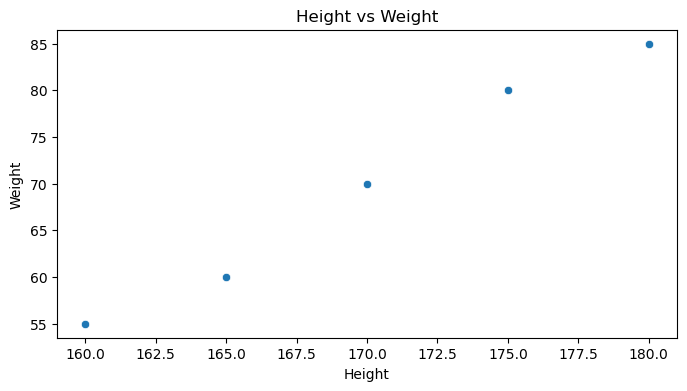

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정 (한글 폰트 깨짐 방지 등은 별도 설정 필요)
plt.figure(figsize=(8, 4))

# 1. 산점도 (Scatter Plot) 시각화
# 키와 몸무게의 관계를 점으로 표현합니다.
sns.scatterplot(x='Height', y='Weight', data=df_health)
plt.title('Height vs Weight')

# 시각화 이미지는 주피터 노트북 내에 인라인으로 표시됩니다.
# plt.show()

"""
[ 🛠️ 상세 주석 및 분석 ]

1. Seaborn vs Matplotlib:
   - Matplotlib은 그래프의 뼈대를 그리는 저수준 라이브러리이고, Seaborn은 이를 기반으로 더 예쁘고 통계적인 기능을 제공하는 고수준 라이브러리입니다.
   - 실무에서는 Seaborn으로 빠르게 그리고, 세부 조정이 필요할 때 Matplotlib 함수를 섞어 씁니다.
   
2. 주요 그래프:
   - 분포 확인: distplot, histplot
   - 관계 확인: scatterplot, heatmap
   - 범주 비교: barplot, boxplot (이상치 탐지에 유용)
"""